# *Lecture 17*

# Systems of Ordinary Differential Equations

| |
|:---:|
|Selected Content [From **COMPUTATIONAL PHYSICS**, 3rd Ed, 2015](http://physics.oregonstate.edu/~rubin/Books/CPbook/index.html) <br>RH Landau, MJ Paez, and CC Bordeianu (deceased) <br>Copyrights: <br> [Wiley-VCH, Berlin;](http://www.wiley-vch.de/publish/en/books/ISBN3-527-41315-4/) and [Wiley & Sons, New York](http://www.wiley.com/WileyCDA/WileyTitle/productCd-3527413154.html)<br>  R Landau, Oregon State Unv, <br>MJ Paez, Univ Antioquia,<br> C Bordeianu, Univ Bucharest, 2015.<br> Support by National Science Foundation.|


### Adaptive Step Sizes in Runge-Kutta Method

The freedom to choose the step size of the independent variable (almost always time) allows us to adjust the $\mathcal{O}(h^4)$ accuracy of the Runge-Kutta method.
The step size may even be changed at every step, if necessary.

Perhaps the easiest way to adjust the step size is to double or halve it, then check to see if the different step size makes a difference in the calculated $y_{n+1}-y_n$.

For example, imagine that the difference $y_{n+1}-y_n$ is 1.01 with step size 0.050.
If the step is halved (0.025), you will need to take 2 steps to match the original step.  So if you find that $y_{n+2}-y_n$ is now 0.98, then you will know that your accuracy is not better than 3%.
If better accuracy is needed, then you will need to halve the step again, take 4 steps, and check that the difference is stable to that accuracy.

This can be considered a "brute-force" approach that doesn't use the "big-O" knowledge of the algorithm.

### Runge-Kutta-Fehlberg Method ('rkf45')

The RKF45 method uses a sequence of function evaluations to calculate solutions with $\mathcal{O}(h^5)$ (5th-order) or $\mathcal{O}(h^4)$ (4th-order).  These two results can be compared directly to give an estimate of the error, at the same time as the result!

\begin{cases}
F_1 = h f(t,y) \\
F_2 = h f \left(t + \frac{1}{4}h, y + \frac{1}{4}F_1 \right)\\
F_3 = h f \left(t + \frac{3}{8}h, y + \frac{3}{32} F_1 + \frac{9}{32} F_2 \right) \\
F_4 = h f \left(t + \frac{12}{13}h, y + \frac{1932}{2197}F_1 - \frac{7200}{2197} F_2 + \frac{7296}{2197} F_3 \right) \\
F_5 = h f \left(t + h, y + \frac{439}{216} F_1 - 8 F_2 + \frac{3680}{513} F_3 - \frac{845}{4104} F_4 \right) \\
F_6 = h f \left(t + \frac{1}{2}h, y - \frac{8}{27}F_1 + 2 F_2 - \frac{3544}{2565}F_3 + \frac{1859}{4104} F_4 - \frac{11}{40} F_5 \right)
\end{cases}

And then

$$y(t+h) = y(t) + \frac{16}{35} F_1 + \frac{6656}{12825}F_3 + \frac{28561}{56430} F_4 - \frac{9}{50} F_5 + \frac{2}{55} F_6 + \mathcal{O}(h^5)$$

or 

$$y(t+h) = y(t) + \frac{25}{216} F_1 + \frac{1408}{2565} F_3 + \frac{2197}{4104} F_4 - \frac{1}{5} F_5 + \mathcal{O}(h^4)$$

The step is still halved or doubled, as in the brute-force method, but this time there is a more precise estimate of the accuracy, and there is no need to overshoot the step size adjustment.

In [19]:
#rk45.py, Notebook Version
# This is actually rkf45.py (Runge-Kutta-Fehlberg)

import matplotlib.pyplot as plt          #Load Matplotlib
import numpy as np

#   Initialization
a = 0.
b = 10.
Tol = 1.0E-8                           # Error tolerance, endpoints
                                        
ydumb = np.zeros((2), float)
y = np.zeros((2), float)
fReturn = np.zeros((2), float)
err = np.zeros((2), float)

k1 = np.zeros((2), float)
k2 = np.zeros((2), float)
k3 = np.zeros((2), float)
k4 = np.zeros((2), float)
k5 = np.zeros((2), float)
k6 = np.zeros((2), float)
n = 20  
yy1=np.zeros((452),float)
yy2=np.zeros((452),float)
tt=np.zeros((452),float)
y[0] = 1. 
y[1] = 0.

h = (b-a)/n
hmin=h/64
hmax=h*64                # min max step sizes
t = a
j=0
flops =0
Eexact =0.
error=0.
sum =0.
tt[0]=t
yy1[0]=y[0]
yy2[0]=y[1]
jj=0
"""Our Function ODE?"""
def f(t, y, fReturn ):
    fReturn[0] = y[1]           # Velocity 
    fReturn[1] =  -6.*pow(y[0], 5.) # Modified in place - Acceleration 
    
plt.figure(1)                         
plt.subplot(2,1,1)                    # 1st subplot in figure
#plot(t,y[0],'r',lw=2)
while (t < b):
    yy1[jj]=y[0]
    yy2[jj]=y[1]
    tt[jj]=t
                                            
    if ( (t + h) > b ):           # Loop over time
        h = b - t                 # Last step
    f(t, y, fReturn)              # Evaluate both RHS's, return in fReturn
    k1[0] = h*fReturn[0];     k1[1] = h*fReturn[1]
    for i in range(0,2):
        ydumb[i] = y[i] + k1[i]/4 
    f(t + h/4, ydumb, fReturn) 
    k2[0] = h*fReturn[0];     k2[1] = h*fReturn[1] 
    for i in range(0,2):
        ydumb[i] = y[i]+3*k1[i]/32 + 9*k2[i]/32
    f(t + 3*h/8, ydumb, fReturn) 
    k3[0] = h*fReturn[0];  k3[1] = h*fReturn[1] 
    for i in range(0,2):
        ydumb[i] = y[i] + 1932*k1[i]/2197-7200*k2[i]/2197. + 7296*k3[i]/2197 
    f(t + 12*h/13, ydumb, fReturn) 
    k4[0] = h*fReturn[0]; k4[1] = h*fReturn[1]   
    for i in range(0,2):
        ydumb[i] = y[i]+439*k1[i]/216 -8*k2[i]+ 3680*k3[i]/513 -845*k4[i]/4104 
    f(t + h, ydumb, fReturn) 
    k5[0] = h*fReturn[0]; k5[1] = h*fReturn[1]   
    for i in range(0,2):
        ydumb[i] = y[i] -8*k1[i]/27 + 2*k2[i]-3544*k3[i]/2565 + 1859*k4[i]/4104 -11*k5[i]/40 
    f(t + h/2, ydumb, fReturn) 
    k6[0] = h*fReturn[0]; k6[1] = h*fReturn[1]; 
    for i in range(0,2):
        err[i] = abs( k1[i]/360 - 128*k3[i]/4275 - 2197*k4[i]/75240 + k5[i]/50. +2*k6[i]/55)
    if ( err[0] < Tol or err[1] < Tol or h <= 2*hmin ):
        # Accept step size
        for i in range(0,2):
            y[i] = y[i] + 25*k1[i]/216. + 1408*k3[i]/2565. + 2197*k4[i]/4104. - k5[i]/5.
        t = t + h 
        j = j + 1  
    """ Edit Below here """ 
    if ( err[0]==0 or err[1]==0 ):
        s = 0                      # Trap division by 0
    else:
        s = 0.84*pow(Tol*h/err[0], 0.25)                      #Reduce step
    if ( s  <  0.75 and h > 2*hmin ):
        h /= 2.                       # Increase step
    else:
        if ( s > 1.5 and 2* h  <  hmax ):
            h *= 2.      
    flops = flops +1 
    E = pow(y[0], 6.) + 0.5*y[1]*y[1] 
    Eexact = 1.  
    error = abs((E-Eexact)/Eexact)       
    sum += error  
    jj +=1
print(" < error> =  ",(sum/flops) )
print("flops = ",flops  )    
    
plt.plot(tt,yy1,'r') 
plt.grid(True)
plt.ylabel('Y(0)')
plt.subplot(2,1,2)
plt.plot(tt,yy2,'b')
plt.grid(True)
plt.xlabel('t')
plt.ylabel('Y(1)') # velocity 

plt.show()


<IPython.core.display.Javascript object>

 < error> =   2.956865652360389e-07
flops =  452


above fig different from oscillator 
same period, shifted by some phase ~ +- pi/2 
F1 positon 
F2 velocity 
higher order power oscillators (have sharper potential edges?)
flats: constant velocity in between the walls, then drastic change at the walls 

In [20]:
#rk45.py, Corrected version
# This is actually rkf45.py (Runge-Kutta-Fehlberg)

import matplotlib.pyplot as plt          #Load Matplotlib
import numpy as np

#   Initialization
a = 0.
b = 10.
Tol = 1.0E-8                           # Error tolerance, endpoints
                                        
ydumb = np.zeros((2), float)
y = np.zeros((2), float)
fReturn = np.zeros((2), float)
err = np.zeros((2), float)

k1 = np.zeros((2), float)
k2 = np.zeros((2), float)
k3 = np.zeros((2), float)
k4 = np.zeros((2), float)
k5 = np.zeros((2), float)
k6 = np.zeros((2), float)
n = 20
yy1=[]
yy2=[]
tt=[]
y[0] = 1. 
y[1] = 0.

h = (b-a)/n
hmin=h/64
hmax=h*64                # min max step sizes
t = a
j=0
flops =0
Eexact =0.
error=0.
sum =0.
tt.append(t)
yy1.append(y[0])
yy2.append(y[1])
jj=0

def f( t, y, fReturn ):
    fReturn[0] = y[1]               #RHS 1st eq
    fReturn[1] =  -6.*pow(y[0], 5.)  #RHS 2nd 
    
while (t < b):
    yy1.append(y[0])
    yy2.append(y[1])
    tt.append(t)
    #Loop over time
                                            
    if ( (t + h) > b ):
        h = b - t                 # Last step
    f(t, y, fReturn)              #Evaluate both RHS's, return in fReturn
    k1[0] = h*fReturn[0];     k1[1] = h*fReturn[1]
    for i in range(0,2):
        ydumb[i] = y[i] + k1[i]/4 
    f(t + h/4, ydumb, fReturn) 
    k2[0] = h*fReturn[0];     k2[1] = h*fReturn[1] 
    for i in range(0,2):
        ydumb[i] = y[i]+3*k1[i]/32 + 9*k2[i]/32
    f(t + 3*h/8, ydumb, fReturn) 
    k3[0] = h*fReturn[0];  k3[1] = h*fReturn[1] 
    for i in range(0,2):
        ydumb[i] = y[i] + 1932*k1[i]/2197-7200*k2[i]/2197. + 7296*k3[i]/2197 
    f(t + 12*h/13, ydumb, fReturn) 
    k4[0] = h*fReturn[0]; k4[1] = h*fReturn[1]   
    for i in range(0,2):
        ydumb[i] = y[i]+439*k1[i]/216 -8*k2[i]+ 3680*k3[i]/513 -845*k4[i]/4104 
    f(t + h, ydumb, fReturn) 
    k5[0] = h*fReturn[0]; k5[1] = h*fReturn[1]   
    for i in range(0,2):
        ydumb[i] = y[i] -8*k1[i]/27 + 2*k2[i]-3544*k3[i]/2565 + 1859*k4[i]/4104 -11*k5[i]/40 
    f(t + h/2, ydumb, fReturn) 
    k6[0] = h*fReturn[0]; k6[1] = h*fReturn[1]; 
    for i in range(0,2):
        err[i] = abs( k1[i]/360 - 128*k3[i]/4275 - 2197*k4[i]/75240 + k5[i]/50. +2*k6[i]/55)
    if ( err[0] < Tol or err[1] < Tol or h <= 2*hmin ):
        # Accept step size
        for i in range(0,2):
            y[i] = y[i] + 25*k1[i]/216. + 1408*k3[i]/2565. + 2197*k4[i]/4104. - k5[i]/5.
        t = t + h 
        j = j + 1  
    ""
    if ( err[0]==0 or err[1]==0 ):
        s = 0                      # Trap division by 0
    else:
        s = 0.84*pow(Tol*h/err[0], 0.25)  
    if ( s  <  0.75 and h > 2*hmin ):
        h /= 2.                       # Reduce step
        print('decreased step to %.3f at (t,y) = (%.2f, %.2f)'% (h, t, y[0]))
    else:
        if ( s > 1.5 and 2* h  <  hmax ):
            h *= 2.                   # Increase step
            print('increased step to %.3f at (t,y) = (%.2f, %.2f)' % (h, t, y[0]))
    flops = flops +1 
    E = pow(y[0], 6.) + 0.5*y[1]*y[1] 
    Eexact = 1.  
    error = abs((E-Eexact)/Eexact)       
    sum += error  
    jj +=1
print(" < error> =  ",(sum/flops) )
print("flops = ",flops  )    

plt.figure(figsize=(12,4))
plt.subplot(2,1,1)
plt.plot(tt,yy1,'r') 
plt.grid(True)
plt.ylabel('Y(0)')
plt.subplot(2,1,2)
plt.plot(tt,yy2,'b')
plt.grid(True)
plt.xlabel('t')
plt.ylabel('Y(1)')

plt.show()

decreased step to 0.250 at (t,y) = (0.00, 1.00)
decreased step to 0.125 at (t,y) = (0.00, 1.00)
decreased step to 0.062 at (t,y) = (0.00, 1.00)
decreased step to 0.031 at (t,y) = (0.00, 1.00)
decreased step to 0.016 at (t,y) = (0.03, 1.00)
increased step to 0.031 at (t,y) = (0.42, 0.62)
increased step to 0.062 at (t,y) = (0.45, 0.57)
decreased step to 0.031 at (t,y) = (0.45, 0.57)
increased step to 0.062 at (t,y) = (0.80, 0.09)
decreased step to 0.031 at (t,y) = (0.98, -0.18)
decreased step to 0.016 at (t,y) = (1.33, -0.66)
increased step to 0.031 at (t,y) = (2.14, -0.61)
increased step to 0.062 at (t,y) = (2.17, -0.57)
decreased step to 0.031 at (t,y) = (2.17, -0.57)
increased step to 0.062 at (t,y) = (2.52, -0.09)
decreased step to 0.031 at (t,y) = (2.70, 0.18)
decreased step to 0.016 at (t,y) = (3.05, 0.66)
increased step to 0.031 at (t,y) = (3.45, 1.00)
decreased step to 0.016 at (t,y) = (3.48, 0.99)
increased step to 0.031 at (t,y) = (3.86, 0.61)
increased step to 0.062 at (t,y) =

<IPython.core.display.Javascript object>

above: more efficient solution to the problem with adaptive step size 

## Second-Order ODEs

We used the vector implementation of the Runge-Kutta method above to solve the arbitrary system

$$\begin{align}
\frac{dy^{(0)}}{dt} &= y^{(1)}(t) ,\\
\frac{dy^{(1)}}{dt} &= -100 y^{(0)} -2 y^{(1)} + 10 \sin(3t)
\end{align}$$

This might correspond to the differential equation

$$\frac{d^2 y}{dt^2} = -100 y - 2 v_y + 10 \sin(3t)$$

(Note that the term $-\gamma v$ can be interpreted as a drag force term.)

In this way, we can solve all manner of physical problems that are described by Newton's Second Law or the Euler-Lagrange equations.

let ? or use characteristic equaiton $e^ix$
$$ u = \frac{dy}{dt}$$
$$ u'= -100y -2v_y + 10sin(3t)$$


### Physics Application: Simple Pendulum

<img src="Figures/simple_pendulum.png" width="20%">

The equation of motion for a simple pendulum assumes a "position" coordinate that is the angle $\theta$.

$$\ddot{\theta} = -\frac{g}{L} \sin\theta$$

In the small-angle approximation $\sin\theta \approx \theta$, this is simple harmonic motion.

We treat the second-order differential equation now as a system of two first-order equations by defining the variables:

$$\begin{align}
y^{(0)} &= \theta \\
y^{(1)} &= \dot\theta \\
\end{align}$$

Then the first-order equations are
$$\begin{align}
\frac{dy^{(0)}}{dt} &= \dot\theta = y^{(1)} \\
\frac{dy^{(1)}}{dt} &= -\frac{g}{L} \sin y^{(0)} = f\left(t, y^{(0)}, y^{(1)}\right) \\
\end{align}$$


assumptions: 
- mass is constant 
- dx/dt = F/m 
- do not assume $\theta = sin(\theta$)

In [21]:
# Simple pendulum based on rk4 implementation

import matplotlib.pyplot as plt          #Load Matplotlib
import numpy as np

#   Initialization
a = 0.
b = 10.
n = 100                                          
ydumb = np.zeros(2)
y = np.zeros(2)
tt=np.zeros(n+2)
yy1=np.zeros(n+2)
yy2=np.zeros(n+2)
fReturn = np.zeros(2)
k1 = np.zeros(2)
k2 = np.zeros(2)
k3 = np.zeros(2)
k4 = np.zeros(2)
y[0] = 1.5 #-----------change this IC value and change L to see period change 
y[1] = 0.0
t = a
tt[0]=t
yy1[0]=y[0]
yy2[0]=y[1]
h = (b-a)/n;

"""change the 1st or 2nd line of the function below, pendulum of length 1"""
def f( t, y, fReturn ):  # function to return RHS (force function)
    g = 9.80
    L = 1.0
    fReturn[0] = y[1]                                                    # RHS 1st eq
    fReturn[1] = -g/L*np.sin(y[0])

j=0
while (t < b):                                                            # Time loop
    if ( (t + h) > b ): 
        h = b - t                                         # Last step
    f(t, y, fReturn)                              # Evaluate RHS's, return in fReturn
    k1[0] = h*fReturn[0];  k1[1] = h*fReturn[1]   # Compute function values
    for i in range(0, 2): ydumb[i] = y[i] + k1[i]/2. 
    f(t + h/2., ydumb, fReturn) 
    k2[0] = h*fReturn[0];  k2[1] = h*fReturn[1] 
    for i in range(0, 2):  ydumb[i] = y[i] + k2[i]/2. 
    f(t + h/2., ydumb, fReturn)
    k3[0] = h*fReturn[0];  k3[1] = h*fReturn[1] 
    for i in range(0, 2): ydumb[i] = y[i] + k3[i] 
    f(t + h, ydumb, fReturn) 
    k4[0] = h*fReturn[0];   k4[1] = h*fReturn[1]  
    for i in range(0, 2): 
        y[i] = y[i] + (k1[i] + 2.*(k2[i] + k3[i]) + k4[i])/6.
    j+=1 
    t+=h
    tt[j]=t
    yy1[j]=y[0]  
    yy2[j]=y[1]

plt.figure(figsize=(10,6))                         
plt.subplot(2,1,1)                    # 1st subplot in figure
plt.plot(tt,yy1,'r') 
plt.grid(True)
plt.ylabel('Y(0) = theta')
plt.subplot(2,1,2)
plt.plot(tt,yy2,'b')
plt.grid(True)
plt.xlabel('t')
plt.ylabel('Y(1) = omega')
plt.show()

<IPython.core.display.Javascript object>

the above, is examining the large angle values of the oscillator 

## Phase Space Diagrams

In the examples above, we followed the position and velocity separately as a function of time.
But in mechanics we are interested in the relationship between the position $x$ and momentum $p=mv$, regardless of the time.
The phase space trajectory in the $(x,p)$ space shows how the system evolves and can show how it balances kinetic and potential energy.
For conservative systems, energy is conserved, and the area enclosed by the phase space trajectory is a measure of the energy.

Even non-linear systems can approach a **limit cycle**, or attractor in phase space, independent of the initial conditions.

### Example: Classical Simple Harmonic Oscillator test bench
The total energy is 

$$E=\frac{p^2}{2m}+\frac{1}{2}kx^2 $$

where $m$ is the mass, $p$ is the momentum $p=m\dot{x}$, and $k$ is the linear spring constant. For coding convenience and to strip the problem down to its essential features, we set $m=k=1$, so the angular frequency and period are

$$\omega=\sqrt{\frac{k}{m}}=1 \:\:\:\:\: T=\frac{2\pi}{\omega}=2\pi$$

Without any damping or external forces, $E$ is constant:

$$2E=p^2+x^2$$

and the phase space plot (trajectory in the $xp$ plane) should simply be a circle of radius $\sqrt{2E}$. These characteristics provide good tests for our methods.

The equation of motion is $\ddot{x}=-x$ ( *i.e.,* $F=-kx$ for a linear spring), so we have

$$ \dot{p}=-x \\ \dot{x}=p $$

Notice, we've taken one second-order differential equation and made it two coupled first-oder differential equations. We will see this many times.

The above pair of equations is the essence of the classical simple harmonic oscillator. Let's solve this numerically and compare the results. We'll start at $x=1$ from rest, with a step size of 1/50th of a period, and watch for several periods.

### General solver code
In the code below, we include Euler, rk2, and rk4 methods so that we can compare them later.

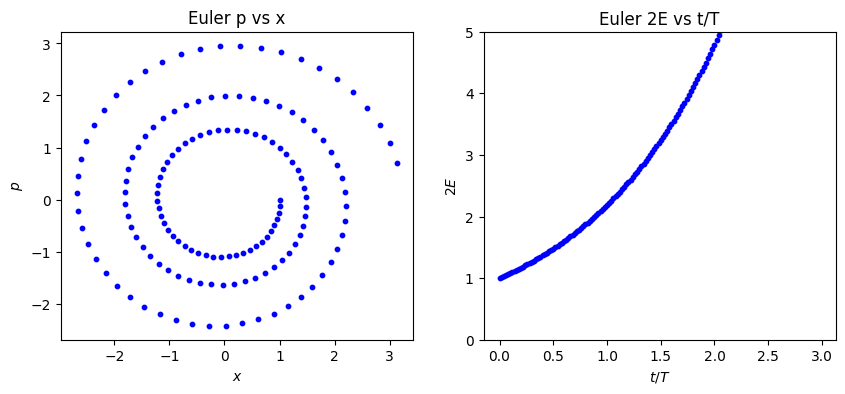

In [22]:
# Euler, rk2, and rk4 - all methods all at once 
%matplotlib inline
%matplotlib inline
T=2.*np.pi
h=T/50.     # change this and explore!!!!!!!!!!!!!!!!!!!!!!
ttot=3.*T
#
figwidth=4
figheight=4
#
t=np.arange(0.,ttot,h)
xe = np.zeros(len(t)).astype('float')
pe = np.zeros(len(t)).astype('float')
xrk2 = np.zeros(len(t)).astype('float')
prk2 = np.zeros(len(t)).astype('float')
xrk4 = np.zeros(len(t)).astype('float')
prk4 = np.zeros(len(t)).astype('float')
xe[0]=xrk2[0]=xrk4[0]=1.
pe[0]=prk2[0]=prk4[0]=0.
for i in range(1,len(t)): # recall, indexing counts starting from 0    
    # Euler:
    xe[i]=xe[i-1]+pe[i-1]*h
    pe[i]=pe[i-1]-xe[i-1]*h
    # RK2
    xrk2[i]=xrk2[i-1]*(1-h*h/2.)+prk2[i-1]*h
    prk2[i]=prk2[i-1]*(1-h*h/2.)-xrk2[i-1]*h # Adjust this to see what happens? qqqq
     # RK4
    k1x=prk4[i-1]
    k1p=-xrk4[i-1]
    k2x=prk4[i-1]+h*k1p/2.
    k2p=-(xrk4[i-1]+h*k1x/2.)
    k3x=prk4[i-1]+h*k2p/2.
    k3p=-(xrk4[i-1]+h*k2x/2.)
    k4x=prk4[i-1]+h*k3p
    k4p=-(xrk4[i-1]+h*k3x)
    xrk4[i]=xrk4[i-1]+h*(k1x+2.*k2x+2.*k3x+k4x)/6.
    prk4[i]=prk4[i-1]+h*(k1p+2.*k2p+2.*k3p+k4p)/6.

plt.figure(figsize=[10, 4])
plt.subplot(1,2,1)    
plt.title('Euler p vs x')
plt.scatter(xe, pe, 10, 'b')
plt.xlabel('$x$')                 #labels
plt.ylabel('$p$')
E2e=(pe*pe+xe*xe)
plt.subplot(1,2,2)    
plt.ylim([0., 5.])
plt.title('Euler 2E vs t/T')
plt.scatter(t/T, E2e, 10, 'b')
plt.xlabel('$t/T$')                 #labels
plt.ylabel('$2E$')
plt.show()

**This is not good!**

Recall, the phase space plot should be a closed circle of radius 1, and the energy should be a constant $2E=1$. The plots can be made more accurate by making $h$ smaller, but after all the above work we know we can do better. 

*By the way: why are the phase space trajectories of oscillators like this clockwise??*

Let's make the same plot with `rk4`, which should be more precise for the same values of $h$.

Euler method is too simplistic for certain motions, energy is not conserved 


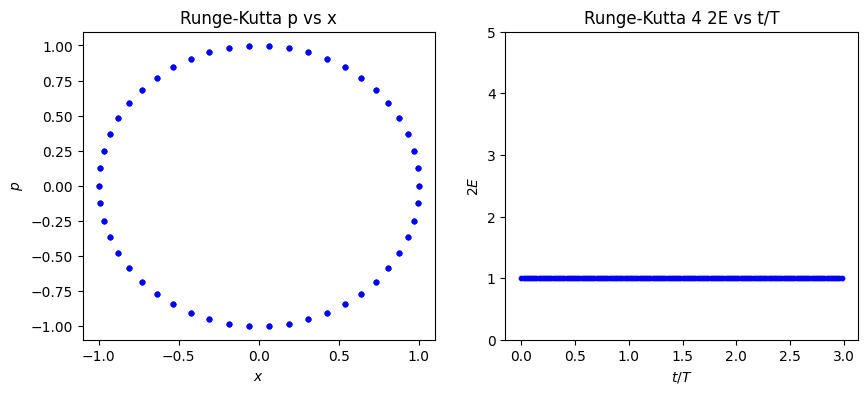

In [23]:
plt.figure(figsize=[10, 4])
plt.subplot(1,2,1)    
plt.title('Runge-Kutta p vs x')
plt.scatter(xrk4, prk4, 10, 'b')
plt.xlabel('$x$')                 #labels
plt.ylabel('$p$')
E2rk4=(prk4**2 + xrk4**2)
plt.subplot(1,2,2)    
plt.ylim([0., 5.])
plt.title('Runge-Kutta 4 2E vs t/T')
plt.scatter(t/T, E2rk4, 10, 'b')
plt.xlabel('$t/T$')                 #labels
plt.ylabel('$2E$')
plt.show()

### Example: Simple Pendulum

We use the results of the simple pendulum, as solved above, to plot the phase space trajectory.

What are the results for 
* small amplitudes (harmonic oscillator)?
* large amplitudes (nonlinear oscillator: periodic but not harmonic)?

From our example, the phase space is defined by position coordinate $\theta$ and velocity coordinate $\omega$ (angular frequency).

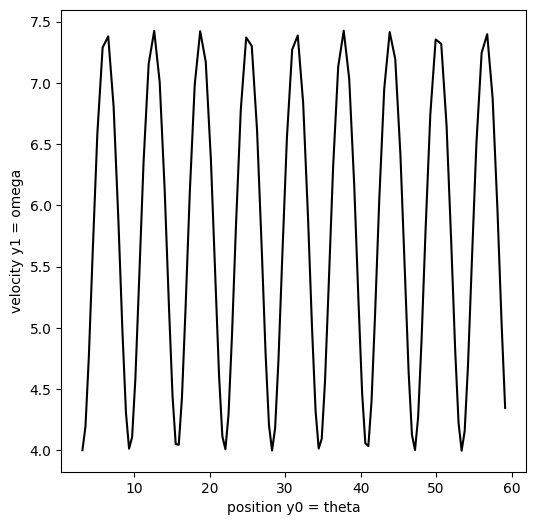

In [29]:
# Phase Space Plot for Simple Pendulum

import matplotlib.pyplot as plt          #Load Matplotlib
import numpy as np

#   Initialization
a = 0.
b = 10.
n = 100                                          
ydumb = np.zeros(2)
y = np.zeros(2)
tt=np.zeros(n+2)
yy1=np.zeros(n+2)
yy2=np.zeros(n+2)
fReturn = np.zeros(2)
k1 = np.zeros(2)
k2 = np.zeros(2)
k3 = np.zeros(2)
k4 = np.zeros(2)
y[0] = np.pi# radians 
y[1] = 4 # radians 
t = a
tt[0]=t
yy1[0]=y[0]
yy2[0]=y[1]
h = (b-a)/n;
def f( t, y, fReturn ):  # function to return RHS (force function)
    fReturn[0] = y[1]                                                    # RHS 1st eq
    fReturn[1] = -9.8/1.0*np.sin(y[0])

j=0
while (t < b):                                                            # Time loop
    if ( (t + h) > b ): 
        h = b - t                                         # Last step
    f(t, y, fReturn)                                      # Evaluate RHS's, return in fReturn
    k1[0] = h*fReturn[0];  k1[1] = h*fReturn[1]           # Compute function values
    for i in range(0, 2): ydumb[i] = y[i] + k1[i]/2. 
    f(t + h/2., ydumb, fReturn) 
    k2[0] = h*fReturn[0];  k2[1] = h*fReturn[1] 
    for i in range(0, 2):  ydumb[i] = y[i] + k2[i]/2. 
    f(t + h/2., ydumb, fReturn)
    k3[0] = h*fReturn[0];  k3[1] = h*fReturn[1] 
    for i in range(0, 2): ydumb[i] = y[i] + k3[i] 
    f(t + h, ydumb, fReturn) 
    k4[0] = h*fReturn[0];   k4[1] = h*fReturn[1]  
    for i in range(0, 2): 
        y[i] = y[i] + (k1[i] + 2.*(k2[i] + k3[i]) + k4[i])/6.
    j+=1 
    t+=h
    tt[j]=t
    yy1[j]=y[0]  
    yy2[j]=y[1]

plt.figure(figsize=(6,6))
plt.plot(yy1, yy2, 'k')
plt.xlabel('position y0 = theta')
plt.ylabel('velocity y1 = omega')
plt.show()

## Example: Double Pendulum

The double pendulum setup has two masses connected by two rigid rods.  The rods are free to pivot around one end.
You treated the double pendulum example in your Mechanics course by assuming small amplitude oscillations, where $\sin\theta \approx \theta$ and $\cos\theta \approx 1- \theta^2/2$.
These approximations allowed for an analytic solution.
Now that we have computational methods to solve the finite amplitude case, we will apply a generic Python ODE method to this system.

Define the following variables:
$$\begin{align}
x_1 &= L_1 \sin\theta_1 \\
x_2 &= L_1 \sin\theta_1 + L_2 \sin\theta_2 \\
y_1 &= -L_1 \cos\theta_1 \\
y_2 &= -L_1 \cos\theta_1 - L_2 \cos\theta_2
\end{align}$$

<img src="Figures/double_pendulum.png" width="50%">

The Euler-Lagrange equations for this system, with no small-angle approximations, give the following two differential equations, mixing up $\ddot{\theta_1}$ and $\ddot{\theta_2}$:

$$\begin{align}
\ddot{\theta_1} &= \frac{-m_2 L_2 \ddot{\theta_2} \cos\left(\theta_2 - \theta_1 \right) + m_2 L_2 \dot\theta_2^2 \sin \left( \theta_2 - \theta_1 \right) - \left( m_1 + m_2 \right) g \sin (\theta_1)}
{\left(m_1 + m_2 \right) L_1} \\
\ddot{\theta_2} &= \frac{-L_1 \ddot{\theta_1} \cos(\theta_2 - \theta_1) - L_1 \dot\theta_1^2 \sin(\theta_2 - \theta_1) - g \sin(\theta_2)}
{L_2}
\end{align}$$

To solve this system, we need to rewrite these as decoupled second-order differential equations.  This can be done by substituting the second equation into the first and vice versa.

$$\begin{align}
\ddot{\theta_1} &= \frac{m_2 L_1 \dot\theta_1^2 \sin(\theta_2 - \theta_1) \cos(\theta_2 - \theta_1) + gm_2 \sin(\theta_2) \cos(\theta_2 - \theta_1) + m_2 L_2 \dot\theta_2^2 \sin(\theta_2 - \theta_1) - (m_1 + m_2) g \sin(\theta_1)}
{L_1 (m_1 + m_2) - m_2 L_1 \cos^2(\theta_2 - \theta_1)} \\
\ddot{\theta_2} &= \frac{-m_2 L_2 \dot\theta_2^2 \sin(\theta_2 - \theta_1) \cos(\theta_2 - \theta_1) - g\sin(\theta_1) \cos(\theta_2 - \theta_1) (m_1 + m_2) - L_1 \dot\theta_1^2 \sin(\theta_2 - \theta_1)(m_1+m_2) -g \sin(\theta_2) (m_1 + m_2) }
{L_2 (m_1 + m_2) - m_2 L_2 \cos^2(\theta_2 - \theta_1)}
\end{align}$$

Since there are now 4 kinematic variables, we will have a system of 4 first-order ODEs, with the following variable definitions:

$$\begin{align}
y_0 &= \theta_1 \\
y_1 &= \dot\theta_1 \\
y_2 &= \theta_2 \\
y_3 &= \dot\theta_2 \\
\end{align}$$

The complete system of first-order ODEs looks like this:
$$\begin{align}
\frac{dy_0}{dt} &= \dot\theta_1 = y_1 \\
\frac{dy_1}{dt} &= \ddot\theta_1 = \frac{m_2 L_1 y_1^2 \sin(y_2 - y_0) \cos(y_2 - y_0) + gm_2 \sin(y_2) \cos(y_2 - y_1) + m_2 L_2 y_3^2 \sin(y_2 - y_0) - (m_1 + m_2) g \sin(y_0)} 
{L_1 (m_1 + m_2) - m_2 L_1 \cos^2(y_2 - y_0)} \\
\frac{dy_2}{dt} &= \dot\theta_2 = y_3 \\
\frac{dy_3}{dt} &= \ddot\theta_2 = 
\frac{-m_2 L_2 y_3^2 \sin(y_2 - y_0) \cos(y_2 - y_0) - g\sin(y_0) \cos(y_2 - y_0) (m_1 + m_2) - L_1 y_1^2 \sin(y_2 - y_0)(m_1+m_2) -g \sin(y_2) (m_1 + m_2) }
{L_2 (m_1 + m_2) - m_2 L_2 \cos^2(y_2 - y_0)} \\
\end{align}$$

In [3]:
%matplotlib widget

# Double pendulum formula translated from the C code at
# http://www.physics.usyd.edu.au/~wheat/dpend_html/solve_dpend.c

import scipy.integrate as integrate
import matplotlib.animation as animation

G = 9.8  # acceleration due to gravity, in m/s^2
L1 = 1.0  # length of pendulum 1 in m
L2 = 1.0  # length of pendulum 2 in m
M1 = 1.0  # mass of pendulum 1 in kg
M2 = 1.0  # mass of pendulum 2 in kg

def derivs(state, t):

    dydx = np.zeros_like(state)
    dydx[0] = state[1]

    del_ = state[2] - state[0]
    den1 = (M1 + M2)*L1 - M2*L1*np.cos(del_)**2
    dydx[1] = (M2*L1*state[1]*state[1]*np.sin(del_)*np.cos(del_) +
               M2*G*np.sin(state[2])*np.cos(del_) +
               M2*L2*state[3]*state[3]*np.sin(del_) -
               (M1 + M2)*G*np.sin(state[0]))/den1

    dydx[2] = state[3]

    den2 = (L2/L1)*den1
    dydx[3] = (-M2*L2*state[3]*state[3]*np.sin(del_)*np.cos(del_) +
               (M1 + M2)*G*np.sin(state[0])*np.cos(del_) -
               (M1 + M2)*L1*state[1]*state[1]*np.sin(del_) -
               (M1 + M2)*G*np.sin(state[2]))/den2

    return dydx

# create a time array from 0..100 sampled at 0.05 second steps
dt = 0.05
t = np.arange(0.0, 20, dt)

# th1 and th2 are the initial angles (degrees)
# w10 and w20 are the initial angular velocities (degrees per second)
th1 = 90.0
w1 = 0.0
th2 = 0.0
w2 = 0.0

# initial state
state = np.radians([th1, w1, th2, w2])

# integrate your ODE using scipy.integrate.
y = integrate.odeint(derivs, state, t)
x1 = L1*np.sin(y[:, 0])
y1 = -L1*np.cos(y[:, 0])

x2 = L2*np.sin(y[:, 2]) + x1
y2 = -L2*np.cos(y[:, 2]) + y1

fig = plt.figure()
ax = fig.add_subplot(111, autoscale_on=False, xlim=(-2, 2), ylim=(-2.1, 2.1))
ax.grid()

line, = ax.plot([], [], 'o-', lw=2)
time_template = 'time = %.1fs'
time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)

def init():
    line.set_data([], [])
    time_text.set_text('')
    return line, time_text


def animate(i):
    thisx = [0, x1[i], x2[i]]
    thisy = [0, y1[i], y2[i]]

    line.set_data(thisx, thisy)
    time_text.set_text(time_template % (i*dt))
    return line, time_text

ani = animation.FuncAnimation(fig, animate, np.arange(1, len(y)),
                              interval=20, blit=True, init_func=init)


ModuleNotFoundError: No module named 'ipympl'

Now we can create the map of the double pendulum's movements in phase space. We will plot the $(\theta_2, \omega_2)$ coordinates to see if there is any pattern we can discern.

This kind of plot is also called a phase space trajectory because it shows the path of the *system* with time. We can follow the phase space evolution with time, or we can observe the overall pattern integrated over all time.

In [37]:
# th1_0 and th2_0 are the initial angles (degrees)
# w1_0 and w2_0 are the initial angular velocities (degrees per second)
th1_0 = 100.0
w1_0 = 5.0
th2_0 = 0.0
w2_0 = 0.0

# initial state
state = np.radians([th1_0, w1_0, th2_0, w2_0])

# integrate your ODE using scipy.integrate.
y = integrate.odeint(derivs, state, t)
th2 = y[:, 2]
w2 =  y[:, 3]

fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(121, autoscale_on=False, xlim=(-4., 4.), ylim=(-10., 10.))
ax1.set_xlabel('theta2')
ax1.set_ylabel('omega2')
ax1.grid()
ax2 = fig.add_subplot(122, autoscale_on=False, xlim=(-3., 3.), ylim=(-3., 3.))

line1, = ax1.plot([], [], '-')
marker1, = ax1.plot([], [], 'o-', markersize=10)
time_template = 'time = %.1fs'
time_text = ax1.text(0.15, 1.2, '', transform=ax.transAxes)

line2, = ax2.plot([], [], 'o-', lw=2)

def init1():
    line1.set_data([], [])
    marker1.set_data([], [])
    time_text.set_text('')
    line2.set_data([], [])
    return line1, marker1, time_text, line2


def animate1(i):
    line1.set_data(th2, w2)
    marker1.set_data(th2[i], w2[i])
    time_text.set_text(time_template % (i*dt))
    thisx = [0, x1[i], x2[i]]
    thisy = [0, y1[i], y2[i]]    
    line2.set_data(thisx, thisy)
    return line1, marker1, time_text, line2

ani = animation.FuncAnimation(fig, animate1, np.arange(1, len(y)),
                            interval=100, blit=True, init_func=init1)

<IPython.core.display.Javascript object>